In [207]:
import pathlib as plb
import nibabel as nib
import numpy as np
import sys, os
from tqdm import tqdm
import scipy
from scipy import ndimage
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [559]:
nii_path = plb.Path('/gpfs/fs0/data/stanford_data/master/')

!ls $nii_path

annotation_for_train  image_for_train_processed


In [582]:
key = 'SUV'
root = plb.Path(nii_path/plb.Path('image_for_train_processed'))
patient_dirs = list(root.glob('*{}*.nii.gz'.format(key)))
patient_dirs = [x for x in patient_dirs if 'suv' in str(x).lower()]
print(patient_dirs[:3])
print(patient_dirs[0].name)
study_names = [x.name for x in patient_dirs]
print()
print(study_names[1])
pet_paths = [plb.Path(os.path.join(nii_path,'image_for_train_processed',name)) for name in study_names]
print(pet_paths[0])

[PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N80_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N74_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N82_SUV2LAVA_deformed.nii.gz')]
N80_SUV2LAVA_deformed.nii.gz

N74_SUV2LAVA_deformed.nii.gz
/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N80_SUV2LAVA_deformed.nii.gz


In [695]:
folder = plb.Path('/gpfs/fs0/data/stanford_data/followup_shashi')
folder = list(folder.glob('*[Ss][Ee][Gg]*.nii.gz'))
print(len(folder))
for path in folder:
    print(path)

71
/gpfs/fs0/data/stanford_data/followup_shashi/LPCH18_FU2_Lavaaligned2BL_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/IBM-CHW-013_FU2_Lavaaligned2BL_flirt_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/IBM-CHW-019_FU2_Lavaaligned2BL_flirt_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/LPCH36_FU1_Lavaaligned2BL_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/IBM-CHW-008_FU1_Lavaaligned2BL_flirt_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/LPCH28_FU1_Lavaaligned2BL_deformedGenericSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/IBM-CHW-020_FU1_Lavaaligned2BL_flirt_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/LPCH18_FU2_Lavaaligned2BL_deformedGenericSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/W104_FU2_Lavaaligned2BL_deformedSeg.nii.gz
/gpfs/fs0/data/stanford_data/followup_shashi/LPCH12_FU2_Lavaaligned2BL_deformedGenericSeg.nii.gz
/gpfs/fs0/data/stanford_data/follo

In [689]:
!ls /gpfs/fs0/data/stanford_data/master/image_for_train_processed/

2015-09__Studies_mri_space3.nii.gz
2015-09__Studies_suvaligned2mri_space3.nii.gz
2017-09__Studies_mri_space3.nii.gz
2017-09__Studies_suvaligned2mri_space3.nii.gz
2018-01__Studies_mri_space3.nii.gz
2018-01__Studies_suvaligned2mri_space3.nii.gz
2018-04__Studies_mri_space3.nii.gz
2018-04__Studies_suvaligned2mri_space3.nii.gz
2018-08__Studies_mri_space3.nii.gz
2018-08__Studies_suvaligned2mri_space3.nii.gz
2018-09__Studies_1_mri_space3.nii.gz
2018-09__Studies_1_suvaligned2mri_space3.nii.gz
2018-09__Studies_2_mri_space3.nii.gz
2018-09__Studies_2_suvaligned2mri_space3.nii.gz
2018-10__Studies_mri_space3.nii.gz
2018-10__Studies_suvaligned2mri_space3.nii.gz
2018-11__Studies_mri_space3.nii.gz
2018-11__Studies_suvaligned2mri_space3.nii.gz
2019-01__Studies_1_mri_space3.nii.gz
2019-01__Studies_1_suvaligned2mri_space3.nii.gz
2019-03__Studies_mri_space3.nii.gz
2019-03__Studies_suvaligned2mri_space3.nii.gz
IBM-CHW-002_suvaligned2mri_space3.nii.gz
IBM-CHW-003_suvaligned2mri_space3.nii.gz
IBM-CHW-004_suv

In [150]:
dftest = pd.read_csv('/gpfs/fs0/data/stanford_data/Test_IDs.csv')
dftest.head(2)

,ID
0,N9
1,N10


In [157]:
study_IDs = dftest['ID'].tolist()
print(study_IDs)
full_nifty_paths = []
for study_id in study_IDs:
    study_path = list(root.glob('{}_*.nii.gz'.format(study_id)))
    full_nifty_paths.extend(study_path)
print(full_nifty_paths[3])

['N9', 'N10', 'N13', 'N29', 'N32', 'N37', 'N38', 'N39', 'N42', 'N49', 'N55', 'N57', 'N71', 'N72', 'N80', 'N82', 'N85', 'N86', 'N47', 'N67', 'N15']
/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N10_LAVA_space3.nii.gz


In [186]:
pet  = nib.load(nii_path/plb.Path('image_for_train_processed/N9_SUV2LAVA_deformed.nii.gz'))
seg  = nib.load(nii_path/plb.Path('annotation_for_train/N9_manual_space3.nii.gz'))

In [187]:
pet_img = pet.get_fdata()
seg_img = seg.get_fdata()
print(pet_img.shape)
print(seg_img.shape)

(140, 140, 575)
(140, 140, 575)


In [583]:
header = pet.header
print(header) 

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 140 140 575   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 208.918
qoffset_y       : 223.028
qoffset_z       : -1596.5403
srow_x          : [ -3.      0. 

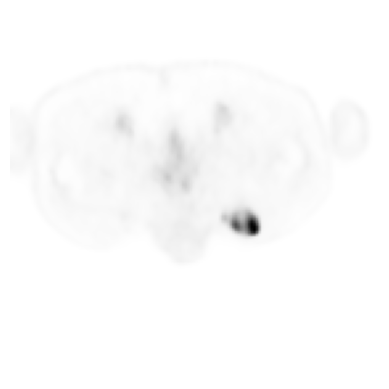

In [189]:
idx = 280
fig,ax=plt.subplots()
ax.set_axis_off()
plt.imshow(np.rot90(pet_img[:,:,idx].copy()),cmap='Greys')

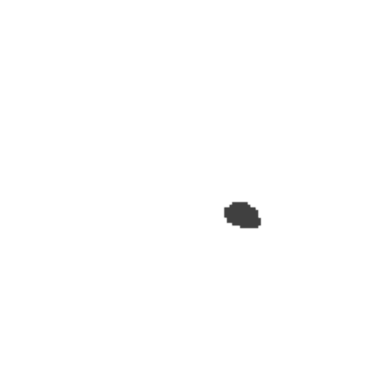

In [190]:
# for i in range(seg_img.shape[2]):
#     if seg_img[:,:,i].any():
#         print(i)
fig,ax=plt.subplots()
ax.set_axis_off()
plt.imshow(np.rot90(seg_img[:,:,idx].copy()),cmap='Greys', vmax=5)

In [380]:
# adapted this so doesn't need to crop/reschale again.
def create_mipNIFTI_from_3D(img, nb_image=48):
    ls_mip=[]
    
    img_data=img.get_fdata()
    shape = img_data.shape
    print(shape)
    diag = int(np.ceil(np.sqrt(np.square(shape[0])+np.square(shape[1]))))
    max_width = max([450, diag])
    target_shape = (shape[2], max_width) # (y_, x_)
    print(target_shape)

    #Modified nifti header saving useful axial slices information
    # Can't seem to create new fields but can use existing fields to store other information...
    header = img.header.copy()
    liver_idx = img_data.shape[-1]//2
    suv_liver = img_data[:,:,liver_idx].squeeze().max()
    suv_brain = img_data[:,:,-1].squeeze().max()
#     print('Liver SUV max', suv_liver)
    header['intent_p1'] = suv_liver
    header['intent_p2'] = suv_brain
    header['intent_p3'] = img_data.max()
    # Can't store too many letters...
    header['intent_name'] = b'liver;brain;max'
    
#     print('Interpolating')
    img_data+=1e-5
    for angle in tqdm(np.linspace(0,360,nb_image)):
        #ls_slice=[]
        # This step is slow: https://stackoverflow.com/questions/14163211/rotation-in-python-with-ndimage
#         vol_angle= scipy.ndimage.interpolation.rotate(img_data,angle,order=0)
        vol_angle = scipy.ndimage.rotate(img_data,angle,order=0)
        
        MIP=np.amax(vol_angle,axis=1)
        MIP-=1e-5
        MIP[MIP<1e-5]=0
        MIP=np.flipud(MIP.T)
        MIP=to_shape(MIP, target_shape)
        ls_mip.append(MIP)
#         print('angle:', angle, MIP.shape)
    
    new_data = np.dstack(ls_mip) #shape [:,:,i]
    mip_nifti = nib.Nifti1Image(new_data, None, header)
    
    return mip_nifti

# Pad to same shape before stack
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    x_pad = abs((x_-x))
    y_pad = abs((y_-y)) # should be 0
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2),
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant') #Default is 0

In [538]:
num_angles = 48

In [539]:
mip_pet = create_mipNIFTI_from_3D(pet, nb_image=num_angles)

(140, 140, 575)
(575, 450)


100%|███████████████████████████████████████████| 48/48 [00:40<00:00,  1.19it/s]


In [540]:
mip_seg = create_mipNIFTI_from_3D(seg, nb_image=num_angles)

(140, 140, 575)
(575, 450)


100%|███████████████████████████████████████████| 48/48 [00:41<00:00,  1.17it/s]


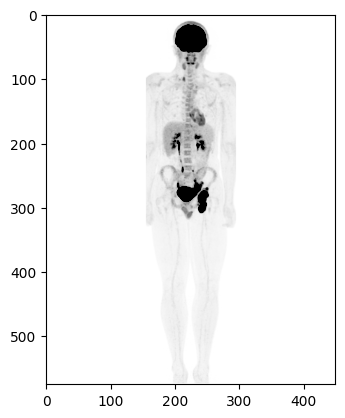

In [455]:
idx = 0
fig,ax=plt.subplots()
# ax.set_axis_off()
plt.imshow(mip_pet.get_fdata()[:,:,idx].copy(),cmap='Greys', vmax=5)

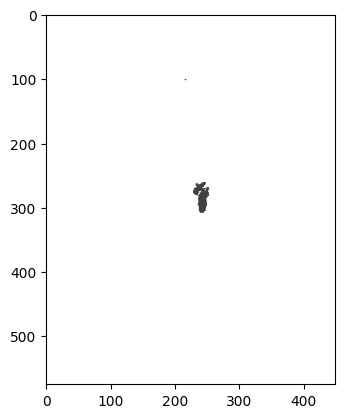

In [194]:
fig,ax=plt.subplots()
# ax.set_axis_off()
plt.imshow(mip_seg.get_fdata()[:,:,idx].copy(),cmap='Greys', vmax=5)

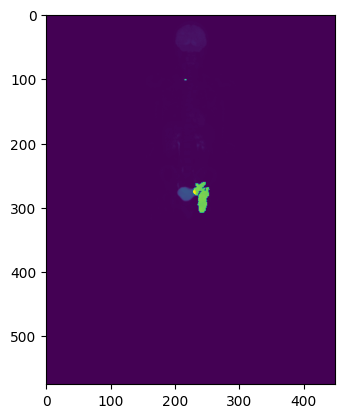

In [195]:
fused = mip_seg.get_fdata()[:,:,idx].copy()*50 + mip_pet.get_fdata()[:,:,idx].copy()
plt.imshow(fused)

In [198]:
def removeXpadding(x, image_width, width=450):
    pad = width//2 - image_width//2
    return x - pad

def rotatepoint(x, y, angle=0, center=(0, 0)):
    a, b = center
    x, y = x-a, y-b  # translate center to (0,0)
    c = np.cos(angle)  # compute cosine of angle
    s = np.sin(angle)  # compute sine of angle
    x, y = x*c+y*s, y*c-x*s  # rotation
    x, y = x+a, y+b  # translate back
    return x, y 



# Project 2D boxes back to orginal 3D coordinates

In [208]:
import os
import glob
import json
from PIL import Image
import torch, torchvision
import torchvision.transforms as T
print(torch.__version__, torch.cuda.is_available())

1.5.1+cu101 True


In [288]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

num_classes = 2

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

finetuned_classes = [
      'N/A', 'tumor',
  ]

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

experiment = 'baseline'

checkpoint = torch.load('../../detr/outputs/{}/checkpoint.pth'.format(experiment),
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();
     

Using cache found in /home/joywu/.cache/torch/hub/facebookresearch_detr_master


In [591]:
def plot_finetuned_results(pil_img, prob=None, boxes=None, labels = True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))   
            if labels:
                cl = p.argmax()
                #print('#', cl,'##', p)
                text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
                ax.text(xmin, ymin, text, fontsize=8,
                      bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def _suv_to_greyPIL(suv_img, suv_max):
    # Assuming eval mode
    norm = plt.Normalize(vmin = 0, vmax = suv_max) # normally radiologists view images at this suv norm
    # Color map to gray images, output has 3 channels
    cmap = plt.cm.Greys
    img = cmap(norm(suv_img))[:,:,:3].copy() # drop the alpha channel that we don't need. has shape (H x W x 3C) 
    #img = torch.as_tensor(img, dtype=torch.float64) # the transforms latera will turn the numpy array to a tensor (C x H x W)
    img = Image.fromarray(np.uint8(img*255), 'RGB') # expected input by transforms
    return img

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs, size, threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], size)

    return probas_to_keep, bboxes_scaled


def run_workflow(mip_stack, model, suv_max = 6, angles = 48, labels = True, threshold = 0.5):
    # Collate predicted bboxes
    bboxes_dict = {}
    for angle in tqdm(range(angles)):
        suv_img = mip_stack[:,:,angle].copy()
        # numpy of pet in suv values
        PIL_image = _suv_to_greyPIL(suv_img, suv_max)
        size = PIL_image.size
        # mean-std normalize the input image (batch-size: 1)
        img = transform(PIL_image).unsqueeze(0)
        # propagate through the model
        outputs = model(img)
        #print('Nth angle:', angle)
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, size, threshold=threshold)
        #print(bboxes_scaled)
        bboxes_dict[angle] = {'boxes':bboxes_scaled.detach().numpy(), # tensor([x_min,y_min,x_max,y_max],[]..)
                              'likelihood':probas_to_keep.detach().numpy()}
        
        #plot_finetuned_results(PIL_image, probas_to_keep, bboxes_scaled, labels = labels)
        
    return bboxes_dict

In [592]:
print('original 3D volume:', pet_img.shape)
mip_stack = mip_pet.get_fdata().copy()
print('2D projected stack of MIP images:', mip_stack.shape)

original 3D volume: (140, 140, 575)
2D projected stack of MIP images: (575, 450, 48)


In [593]:
print(mip_pet.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 575 450  48   1   1   1   1]
intent_p1       : 60.146614
intent_p2       : 0.06258528
intent_p3       : 68.89637
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 208.918
qoffset_y       : 223.028
qoffset_z       : -1596.5403
srow_x        

In [594]:
bboxes_dict = run_workflow(mip_stack, model, suv_max = 6, angles = num_angles, threshold = 0.7)

100%|███████████████████████████████████████████| 48/48 [00:25<00:00,  1.90it/s]


In [590]:
bboxes_dict

{0: {'boxes': array([[209.82956, 236.647  , 214.85503, 245.91995],
         [226.22188, 258.15076, 252.31264, 305.6512 ],
         [248.06834, 269.2669 , 253.04083, 273.0399 ],
         [227.16321, 241.50298, 230.73569, 245.02397]], dtype=float32),
  'likelihood': tensor([[4.1648e-09, 9.0854e-01],
          [2.7827e-08, 9.9796e-01],
          [3.5437e-09, 7.7252e-01],
          [2.6359e-09, 8.7491e-01]], grad_fn=<IndexBackward>)},
 1: {'boxes': array([[224.00488, 240.99554, 227.98164, 245.0985 ],
         [248.28664, 268.72006, 253.87047, 272.73312],
         [209.34724, 237.04395, 214.27176, 246.01852],
         [224.08414, 257.02264, 252.73178, 306.40463]], dtype=float32),
  'likelihood': tensor([[2.5208e-09, 8.7774e-01],
          [2.5020e-09, 7.4949e-01],
          [4.1751e-09, 9.0261e-01],
          [3.3220e-08, 9.9789e-01]], grad_fn=<IndexBackward>)},
 2: {'boxes': array([[201.23457, 271.4847 , 209.7781 , 281.0464 ],
         [223.10974, 240.94954, 227.38196, 245.00328],
        

(450, 450, 575)
(140, 140, 575)

(505, 505, 575)
(140, 140, 575)

(551, 551, 575)
(140, 140, 575)

(588, 588, 575)
(140, 140, 575)

(615, 615, 575)
(140, 140, 575)

(631, 631, 575)
(140, 140, 575)

(636, 636, 575)
(140, 140, 575)

(631, 631, 575)
(140, 140, 575)

(615, 615, 575)
(140, 140, 575)

(588, 588, 575)
(140, 140, 575)

(551, 551, 575)
(140, 140, 575)

(505, 505, 575)
(140, 140, 575)

(450, 450, 575)
(140, 140, 575)

(505, 505, 575)
(140, 140, 575)

(551, 551, 575)
(140, 140, 575)

(588, 588, 575)
(140, 140, 575)

(615, 615, 575)
(140, 140, 575)

(631, 631, 575)
(140, 140, 575)

(636, 636, 575)
(140, 140, 575)

(631, 631, 575)
(140, 140, 575)

(615, 615, 575)
(140, 140, 575)

(588, 588, 575)
(140, 140, 575)

(551, 551, 575)
(140, 140, 575)

(505, 505, 575)
(140, 140, 575)

(450, 450, 575)
(140, 140, 575)

(505, 505, 575)
(140, 140, 575)

(551, 551, 575)
(140, 140, 575)

(588, 588, 575)
(140, 140, 575)

(615, 615, 575)
(140, 140, 575)

(631, 631, 575)
(140, 140, 575)

(636, 636,

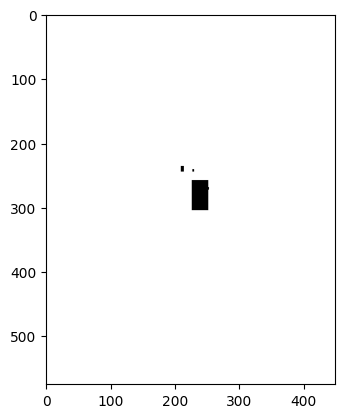

In [544]:
def get_projected_bbox_likelihood(bboxes_dict, mip_stack, pet_img):
    height, width, num_angles = mip_stack.shape
    
    # the width that we will cut down to
    # cut_width = int(width/np.sqrt(2))
    cut_width = pet_img.shape[0]

    together = np.zeros((cut_width, cut_width, height))

    for i in tqdm(range(num_angles)):
        angle = 360*i/num_angles
        boxes = bboxes_dict[i]['boxes']
        box_probs = bboxes_dict[i]['likelihood']

        flat = np.zeros((height, width))
        for j in range(len(boxes)):
            # if max(box_probs[j]) < 0.05: continue           
            xmin, ymin, xmax, ymax = boxes[j]
            xmin = int(xmin)
            xmax = int(xmax)
            ymin = int(ymin)
            ymax = int(ymax)
            flat[ymin:ymax, xmin:xmax] = 1
        #plt.imshow(flat,cmap='Greys')

        # Turn the flat 2D image into 3D image
        fat = np.tile(flat, (width, 1, 1))
        # reorder axes for rotation
        fat = np.transpose(fat, axes=(0,2,1))
        # rotate back
        rot = scipy.ndimage.rotate(fat,-angle,order=0) 
        print(rot.shape)
        # size of the rotated image, which depends on angle
        w = rot.shape[0]
        assert w >= cut_width
        a = (w-cut_width)//2
        b = a + cut_width
        cut = rot[a:b, a:b, :]
        print(cut.shape)
        print()
        together = together + cut
    
    # Reverse the MIP transformations
    # flip whole stack upside down again
    reoriented = np.flipud(together).copy()
    # And rotate back to original orientation
    reoriented = np.rot90(reoriented, k=3) 
    
    return reoriented

In [545]:
reoriented = get_projected_bbox_likelihood(bboxes_dict, mip_stack, pet_img)
print(reoriented.shape)

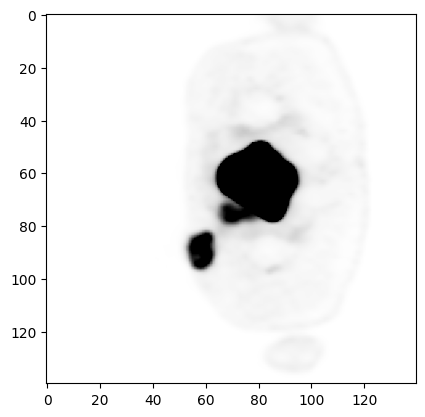

In [626]:
idx = 295
plt.imshow(pet_img[:,:,idx],cmap='Greys', vmax = 6)

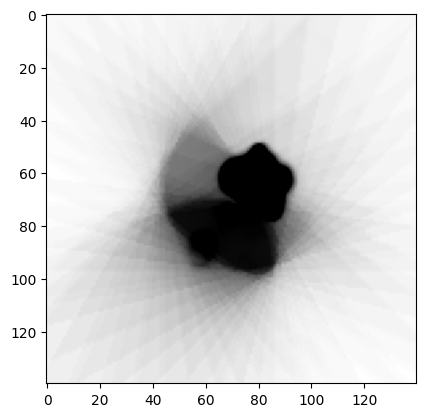

In [550]:
plt.imshow(pet_img[:,:,idx]+reoriented[:,:,idx],cmap='Greys', vmax = 50)

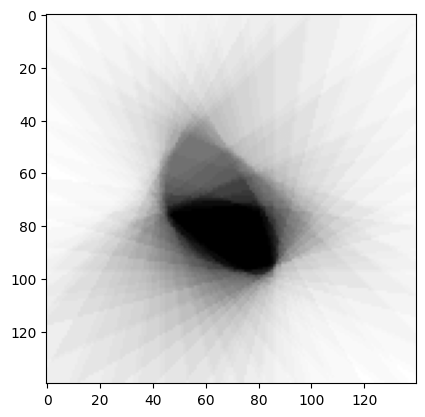

In [548]:
plt.imshow(reoriented[:,:,idx],cmap='Greys')

In [526]:
# Attempt see what's going on in 3D

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=2.5): 
    #p = image.transpose(2,1,0)
    p = image.copy()
    verts, faces, normals, values = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

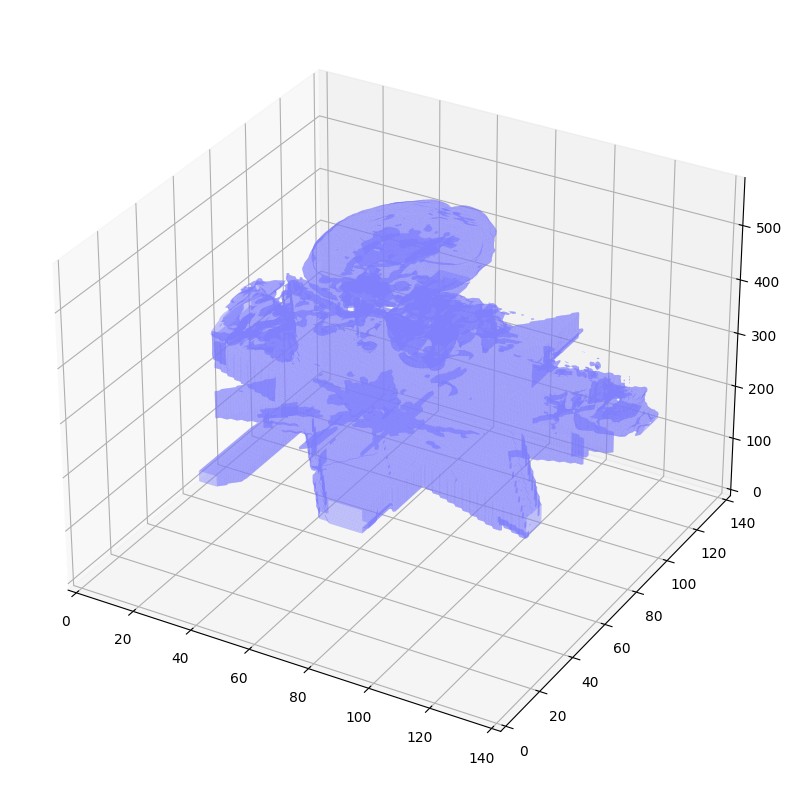

In [527]:
plot_3d(pet_img + reoriented, threshold=2.5)

In [597]:
data_in_root = plb.Path('/gpfs/fs0/data/stanford_data/')
root = plb.Path(data_in_root/plb.Path('petmr_detr_dataset/test/SUV_MIP/'))
study_paths = list(root.glob('*SUV2LAVA*.nii.gz'))
#print(len(study_paths))
#study_paths = [x for x in study_paths if 'suv' in str(x).lower()]
print(len(study_paths))
print(study_paths)

21
[PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N80_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N82_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N85_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N49_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N10_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N86_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N57_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N29_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/test/SUV_MIP/N42_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/petmr_detr_dataset/t

In [613]:
# Back project a single point
def back_project_a_point(coord, nth_angle, mip, pet_img, num_angles = 48):
    x, y = coord
    x, y = int(x), int(y)
    height, width = mip.shape
    angle = 360*nth_angle/num_angles
    # the width that we will cut down to
    cut_width = pet_img.shape[0]
    
    # 3D back projection
    projection = np.zeros((cut_width, cut_width, height))

    flat = np.zeros((height, width))
    flat[y, x] = 1
    # Turn the flat 2D image into 3D image
    fat = np.tile(flat, (width, 1, 1))
    # reorder axes for rotation
    fat = np.transpose(fat, axes=(0,2,1))
    # rotate back
    rot = scipy.ndimage.rotate(fat,-angle,order=0) 
    print(rot.shape)
    # size of the rotated image, which depends on angle
    w = rot.shape[0]
    # cut down to original size of pet_img
    assert w >= cut_width
    a = (w-cut_width)//2
    b = a + cut_width
    cut = rot[a:b, a:b, :]
    print(cut.shape)
    print()
    projection = projection + cut
    print(projection.shape)
    
    # Reverse the MIP transformations
    # flip whole stack upside down again
    reoriented = np.flipud(projection).copy()
    # And rotate back to original orientation
    reoriented = np.rot90(projection, k=3) 
    
    return reoriented

In [617]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(9.0).reshape((3, 3))
np.multiply(x1, x2)

array([[ 0.,  1.,  4.],
       [ 9., 16., 25.],
       [36., 49., 64.]])

In [618]:
x1

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [619]:
x2

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [664]:
idx = 295
thresh = np.max(reoriented)-5
candidates = pet_img.copy()
candidates[candidates < 2] = 0
#candidates[candidates >= 2] = 1
likelihoods = reoriented.copy()
likelihoods[likelihoods < thresh] = 0
predicted = np.multiply(candidates, likelihoods)

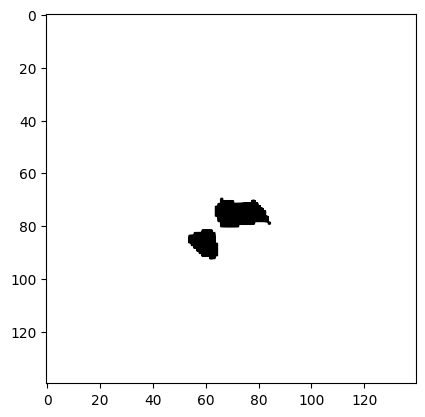

In [665]:
plt.imshow(predicted[:,:,idx],cmap='Greys', vmax = 48)